# Single-row facility layout

## Introduction 

We consider the problem of finding an arrangement of elements of given lengths (facilities, rooms, machines...) on a line so as to minimize the weighted sum of the distances between all the pairs of elements, that is, minimize the traffic intensity.

Thus, the problem can be reduced to finding an ordering.

Here is an illustration of the 3 different (non-symetric) solutions of an example problem with 3 facilities.

![Example](slorp.png "Example")

Each facility is represented by a colored rectangle, with the length of the rectangle corresponding to the facility's size. Black rectangles between the facilities represent the traffic. The length of these black rectangles corresponds to the distance between the centers of the corresponding facilities, and their height corresponds to the traffic intensity. Thus, the objective value corresponds to the sum of the areas of the black rectangles.

In this example, the best solution is the third one. Scissor Lift has high traffic. Therefore, putting it in the middle minimizes the overall traffic.

## Notebook installation requirements 

In [1]:
import subprocess
import sys

def install_requirements():
    try:
        with open('requirements.txt') as f:
            packages = f.read().splitlines()
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-r', 'requirements.txt'])
        print("All packages have been successfully installed.")
    except Exception as e:
        print(f"An error occurred while installing the packages: {e}")

install_requirements()

All packages have been successfully installed.


## Problem description 

**Input**

* A set of $N$ facilities. For each facility $i = 1, \dots, N$, its length $L_{i} \in \mathbb{R}^+$

* The traffic density between each pair of facilities $C_{i,j} \in \mathbb{R}^+$, $i = 1, \dots, N$, $j = i + 1, \dots, N$

**Problem**: find a permutation of facilities

**Objective**: minimize the traffic intensity
$$
\sum_{i = 1}^N \sum_{j = i + 1}^N C_{i, j} l_{i, j}
$$
where $l_{i, j}$ is the distance between facility $i$ and facility $j$ in the solution.

## Mixed-integer nonlinear program

There are various possible models for the problem. We propose here one relying on boolean variables indicating the relative positions between each pair of facilities.

**Variables**:

* $a_{i, j} \in \{ 0 , 1\}$,  $i = 1, \dots, N$, $j = 1, \dots, N$: $a_{i, j} = 1$ if facility $i$ is to the left of facility $j$.

**Objective**:

$$
\min \sum_{i=1}^{N-1} \sum_{j=i+1}^N C_{i, j} \left( \sum_{k=1, k \neq i, k \neq j}^{N} L_k (a_{i, k} a_{k, j} + a_{j, k} a_{k, i}) + \frac{1}{2}(L_i+L_j) \right)
$$

To understand this formula, let's note that $a_{i, k} a_{k, j} + a_{j, k} a_{k, i} = 1$ if facility $k$ is located between facility $i$ and facility $j$. In this case, a cost $C_{i, j} L_k$ is paid. Moreover, the distance between 2 machines is from centre to centre, hence the term $\frac{1}{2}(L_i+L_j)$.

**Constraints**:

* Either facility $i$ is to the left of facility $j$, or facility $j$ is to the left of facility $i$:

$$
\forall i = 1, \dots, N-1, \quad \forall j = i+1, \dots, N \qquad a_{i, j} + a_{j, i} = 1
$$

* If facility $i$ is located before facility $j$ and facility $j$ is located before facility $k$, then facility $i$ must be located before facility $k$:

$$
\forall i = 1, \dots, N, \quad \forall j = i + 1, \dots, N \qquad \forall k = 1, \dots, N \qquad  a_{i, j} + a_{j, k} + a_{k, i} \leq 2
$$

The model has the following properties:
* Binary variables only
* Non-convex quadratic objective and linear constraints only
* Therefore, it is a non-convex BQP (Binary Quadratic Problem)

The number of variables is quadratic in the number of facilities. It is possible to linearize this model by introducing three indices variables $a_{i, j, k}$. However, the number of variables then becomes cubic in the number of facilities and, even if it is linear, the model quickly becomes intractable when the number of facilities increases.

We solve the problem with Artelys Knitro using the Pyomo modeler.

## Input 
It's necessary to have the traffic between two machines and the length of each machine to continue.

In [2]:
nb_machines = 6

machines_lengths = [6, 12, 2, 7, 13, 6]

traffic_matrix =  [
    [0,5,1,10,4,19],
    [0,0,9,10,7,4],
    [0,0,0,6,2,7],
    [0,0,0,0,1,4],
    [0,0,0,0,0,0,4],
    [0,0,0,0,0,0]]

machines_names = ["Lathe", "Drill", "Mill", "Punch press", "Centreless grinder", "Shaper", "Planer"]

## Pyomo model
Let's write the model with Pyomo.

In [3]:
import pyomo.environ as pyo

def build_model(machines_lengths, traffic_matrix):

    nb_machines = len(machines_lengths)
    
    ####################
    # Create variables #
    ####################

    model.N = pyo.RangeSet(0, nb_machines - 1)
    model.a = pyo.Var(model.N, model.N, within = pyo.Binary)
    
    #############
    # Objective #
    #############
    
    model.objective = pyo.Objective(
        expr=pyo.quicksum(
            traffic_matrix[i][j] * (
                pyo.quicksum(
                    machines_lengths[k] * (model.a[i,k] * model.a[k,j]+ model.a[j,k] * model.a[k,i])
                    for k in model.N if k != i and k != j)
                + (machines_lengths[i]+machines_lengths[j])/2)
            for i in model.N
            for j in model.N if j > i),
        sense=pyo.minimize)
    
    ###############
    # Constraints #
    ###############
    
    def symetry_rule(model, i, j):
        if i < j:
            return (model.a[i, j] + model.a[j, i] == 1)  
        else:
            return pyo.Constraint.Skip
    model.constraints_symetry = pyo.Constraint(model.N, model.N, rule=symetry_rule)
    
    def triple_order_room_rule(model, i, j, k):
        if i != j and j != k and k != i:
            return (model.a[i, j] + model.a[j, k] + model.a[k, i] <= 2)
        return pyo.Constraint.Skip 
    model.constraints_triple_order_room = pyo.Constraint(model.N, model.N, model.N, rule=triple_order_room_rule)


# Create a model 
model = pyo.ConcreteModel()

# Build model
build_model(machines_lengths, traffic_matrix)

# Solve model
solver = pyo.SolverFactory('knitroampl')
solver.options["mip_multistart"] = 1
solver.options["mip_maxnodes"] = 2
solver.options["numthreads"] = 1
results = solver.solve(model, tee=True)        

Artelys Knitro 14.1.0: mip_multistart=1
mip_maxnodes=2
numthreads=1

          Commercial License
         Artelys Knitro 14.1.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
mip_maxnodes             2
mip_multistart           1
numthreads               1
The problem is identified as a MIQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changing mip_cut_probing from AUTO to 1.
Knitro ch

# Output visualization

A comparison will be made between the permutation obtained through optimization and a random permutation.

First, let's retrieve the permutation.

In [4]:
# Here is a function which print the order of the machines and return the a list of indexes related to the order of machines

def get_order_machines(nb_machines, machines_names, model):
    permutation_order_with_left_occurences = []
    for i in range(nb_machines):
        counter_i = 0
        for j in range(nb_machines):
            if model.a[i,j]() is not None and model.a[i,j]() >= 0.99:
                counter_i += 1
        permutation_order_with_left_occurences.append([counter_i, i])
        
    permutation_order_with_left_occurences.sort(reverse = True)
    permutation_order = []
    
    for perm in permutation_order_with_left_occurences:
        permutation_order.append(perm[1])

    print("The order of machines from left to right is : ")
    for k in range(nb_machines):
        print(f"* {machines_names[permutation_order[k]]}")
        
    print(f"Total cost is {model.objective()}")
    
    return(permutation_order) 
 
permutation_order = get_order_machines(nb_machines, machines_names, model)

The order of machines from left to right is : 
* Centreless grinder
* Drill
* Mill
* Shaper
* Lathe
* Punch press
Total cost is 1073.500000288226


Now, let's visualize the solution.

In [5]:
def find_left_right_abscissa(index_m1, index_m2, machines_lengths, permutation_order):

    index_pm1 = next(i for i, po in enumerate(permutation_order) if po == index_m1)
    index_pm2 = next(i for i, po in enumerate(permutation_order) if po == index_m2)
    quantity_left = 0

    if index_pm2 < index_pm1:
        first, second = index_pm2, index_pm1
        first_length, second_length = index_m2, index_m1
    else:
        first, second = index_pm1, index_pm2
        first_length, second_length = index_m1, index_m2

    for i in range(first):
        quantity_left += machines_lengths[permutation_order[i]]
    quantity_left += machines_lengths[first_length] / 2
    quantity_right = quantity_left + machines_lengths[first_length] / 2

    for i in range(first + 1, second):
        quantity_right += machines_lengths[permutation_order[i]]
    quantity_right += machines_lengths[second_length] / 2

    return quantity_left, quantity_right


def draw_machine_rectangles(
    fig,
    traffic_matrix,
    machines_lengths,
    machines_names,
    permutation_order,
    quantity_top_init,
):

    for machine_number in range(nb_machines):
        k = 0
        x_left = 0
        while machine_number != permutation_order[k]:
            x_left += machines_lengths[permutation_order[k]]
            k += 1
        x_right = x_left + machines_lengths[permutation_order[k]]
        
        fig.add_scatter(
            x=[x_left,x_left, x_right, x_right],
            y=[0, quantity_top_init,quantity_top_init, 0],
            name=f"{machines_names[machine_number]}",
            mode='lines',
            line=dict(width=0.001),
            fill="toself")


def draw_traffic_rectangles_and_get_total_area(
    fig, traffic_matrix, machines_lengths, permutation_order, quantity_top_init
):

    quantity_left, quantity_right = find_left_right_abscissa(
        0, 1, machines_lengths, permutation_order
    )
    quantity_top = quantity_top_init - 2
    quantity_bot = quantity_top - traffic_matrix[0][1]
    total_area = (traffic_matrix[0][1]) * (quantity_right - quantity_left)

    fig.add_scatter(
        x=[quantity_left, quantity_left, quantity_right, quantity_right],
        y=[quantity_bot, quantity_top, quantity_top, quantity_bot],
        fill="toself",
        marker=dict(color="black"),
        showlegend=False,
        mode="lines",
        line=dict(width=0.001),
        name=f"Area = {(traffic_matrix[0][1])*(quantity_right-quantity_left)}",
    )

    for i in range(len(permutation_order) - 1):
        for j in range(i + 1, len(permutation_order)):
            if i != 0 or j != 1:
                quantity_left, quantity_right = find_left_right_abscissa(
                    i, j, machines_lengths, permutation_order
                )
                quantity_top = quantity_bot - 2
                quantity_bot = quantity_top - traffic_matrix[i][j]
                fig.add_scatter(
                    x=[quantity_left, quantity_left, quantity_right, quantity_right],
                    y=[quantity_bot, quantity_top, quantity_top, quantity_bot],
                    fill="toself",
                    name=f"Area = {(traffic_matrix[i][j])*(quantity_right-quantity_left)}",
                    marker=dict(color="black"),
                    showlegend=False,
                    mode="lines",
                    line=dict(width=0.001),
                )
                total_area += (traffic_matrix[i][j]) * (quantity_right - quantity_left)

    return total_area


In [6]:
import plotly.graph_objects as go


def draw_figure(
    nb_machines,
    machines_lengths,
    traffic_matrix,
    machines_names,
    permutation_order,
    title,
):

    nb_machines = len(machines_lengths)
    nb_rectangles = sum(range(nb_machines))
    total = sum(sum(row) for row in traffic_matrix)
    quantity_top_init = total + (nb_rectangles + 1) * 2

    fig = go.Figure()

    # Here we draw machine rectangles
    draw_machine_rectangles(
        fig,
        traffic_matrix,
        machines_lengths,
        machines_names,
        permutation_order,
        quantity_top_init,
    )

    # Here we draw quantites rectangles and return the sum of total areas
    total_area = draw_traffic_rectangles_and_get_total_area(
        fig, traffic_matrix, machines_lengths, permutation_order, quantity_top_init
    )

    fig.update_layout(title=title)
    fig.update_layout(autosize=False, width=1024, height= 16*nb_machines**2,  yaxis=dict(range=[-1, quantity_top_init+5]))
    fig.show("png")

    print(f"Total cost(sum of areas) = {total_area}")


Random permutation
[3, 5, 4, 0, 2, 1]


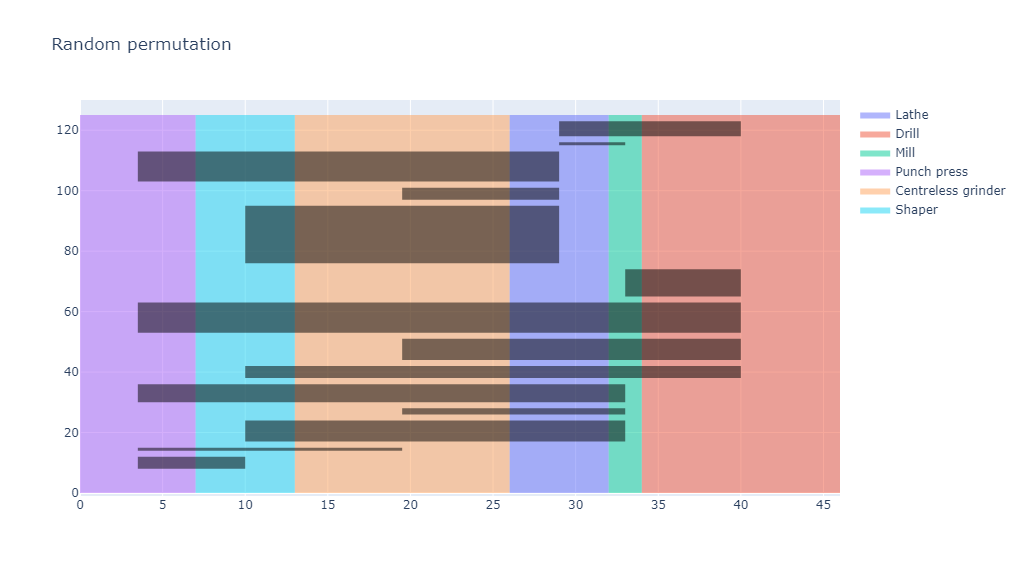

Total cost(sum of areas) = 1811.5


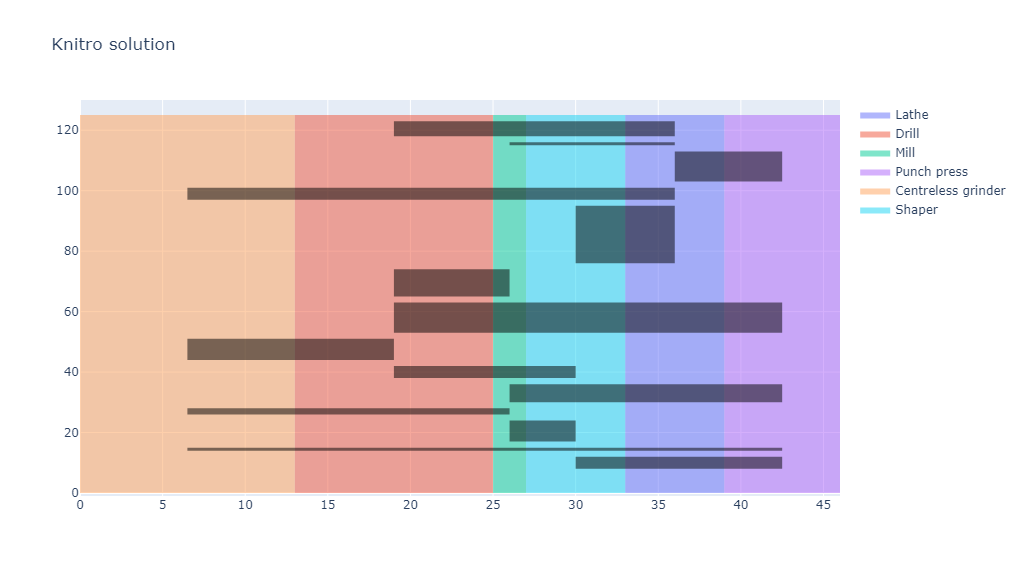

Total cost(sum of areas) = 1073.5


In [7]:
# Let's generate a random permutation to compare the solutions         
import random
random.seed(4)
random_permutation = list(range(nb_machines))
random.shuffle(random_permutation)
print("Random permutation")
print(random_permutation)

# Let's draw figures
draw_figure(nb_machines, machines_lengths, traffic_matrix, machines_names, random_permutation, "Random permutation")
draw_figure(nb_machines, machines_lengths, traffic_matrix, machines_names, permutation_order, "Knitro solution")

# Increasing the number of machines

Let's try another example with a higher number of machines.

In [8]:
import string

# Let's generate random inputs for the last example with a higher number of machines

nb_machines = 40
machines_lengths = []
machines_names = []
traffic_matrix = []
for i in range(nb_machines):
    row = []
    for j in range(nb_machines):
        if j <= i:
            row.append(0)
        else:
            row.append(random.randint(1,15))
    traffic_matrix.append(row)
    machines_lengths.append(random.randint(10,30))
    machines_names.append(''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(6)))

In [9]:
model = pyo.ConcreteModel()

# Build model
build_model(machines_lengths, traffic_matrix)

# Solve model
solver = pyo.SolverFactory('knitroampl')
solver.options["mip_multistart"] = 1
solver.options["mip_maxnodes"] = 2
solver.options["numthreads"] = 1
results = solver.solve(model, tee=True)

Artelys Knitro 14.1.0: mip_multistart=1
mip_maxnodes=2
numthreads=1

          Commercial License
         Artelys Knitro 14.1.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
mip_maxnodes             2
mip_multistart           1
numthreads               1
The problem is identified as a MIQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changing mip_cut_probing from AUTO to 1.
Knitro ch

   71    1.49390e+06      1.36711e-08           2.19560      14.150
   72    1.49368e+06      1.52038e-08           2.19618      14.239
   73    1.49351e+06      1.53926e-08           2.19755      14.389
   74    1.49343e+06      1.87082e-08           2.19747      14.490
   75    1.49272e+06      1.60539e-09           3.23443      15.035
   76    1.49265e+06      5.76411e-09           2.67283      15.136
   77    1.49238e+06      7.94301e-10           2.82892      15.719
   78    1.49234e+06      2.67102e-09           2.27741      15.878
   79    1.49180e+06      5.06962e-10           2.46544      16.213
   80    1.49177e+06      1.24498e-08           2.30611      16.374
   81    1.49175e+06      1.50193e-08           1.97365      16.463
   82    1.49167e+06      3.87400e-10           1.97934      16.820
   83    1.49160e+06      2.14459e-10           2.68798      17.124
   84    1.49139e+06      1.26589e-10           2.68802      17.418
   85    1.49121e+06      7.59097e-11           

  192    1.48342e+06      6.12626e-09           2.56110      38.859
  193    1.48342e+06      1.08146e-08           2.00192      38.927
  194    1.48341e+06      1.75423e-08           1.98487      38.999
  195    1.48340e+06      1.75827e-08           1.98205      39.072
  196    1.48340e+06      1.75733e-08           1.98204      39.140
  197    1.48335e+06      5.68897e-09           1.98204      39.407
  198    1.48313e+06      3.88091e-09           2.55022      39.621
  199    1.48313e+06      3.88187e-09           1.97341      39.695
  200    1.48313e+06      1.59653e-07           1.97333      39.770
  201    1.48313e+06      1.59183e-07           1.80855      39.845
  202    1.48313e+06      4.19677e-08           1.12826      39.924
  203    1.48313e+06      2.39045e-08       1.45950e-02      40.004
  204    1.48313e+06      2.13572e-09       9.39308e-03      40.068
  205    1.48313e+06      4.59781e-09       5.56295e-07      40.136
  206    1.48313e+06      2.99667e-10       3.13

In [10]:
permutation_order = get_order_machines(nb_machines,machines_names,model)

The order of machines from left to right is : 
* SO1U8X
* L2YVL7
* H547E7
* PVBBY1
* KVS4U0
* XZYBJ6
* JNXPWT
* 2ZJQXV
* NHVS9D
* ZYNANK
* 784VJM
* WQV8C8
* 1ULNB4
* ELBLNQ
* MLMFFA
* OMWL8N
* CMEVIT
* DKDQ5G
* WFSUBU
* 8WFDJ8
* S7771E
* N5HVA3
* 6FBZQS
* IDKZ98
* 2N1NHD
* 6102EM
* ZP5OTX
* TZKIY3
* S0CAW7
* EM1F1C
* 4RN4S7
* ULTBB7
* FVY6PL
* CCLJWO
* ZVKYD1
* T4VFPU
* 4HEMKJ
* H59QIC
* N5MCCQ
* 0IF9XA
Total cost is 1481851.0


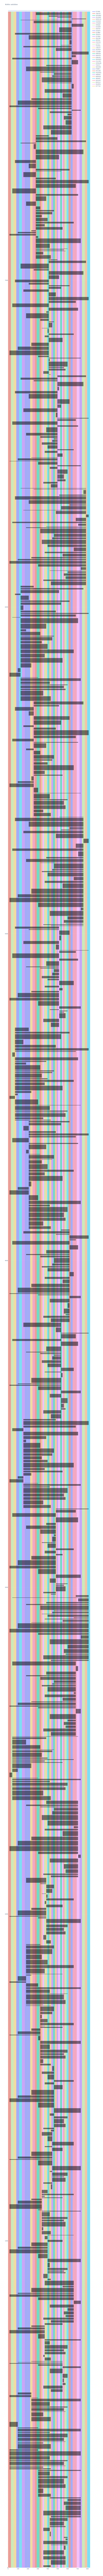

Total cost(sum of areas) = 1481851.0


In [11]:
draw_figure(nb_machines, machines_lengths, traffic_matrix, machines_names, permutation_order, "Knitro solution")